In [11]:
#Lets have matplotlib "inline"
%pylab inline

#Lets have opencl ipython integration enabled
%load_ext pyopencl.ipython_ext

#Import packages we need
import numpy as np
import pyopencl as cl
from mpl_toolkits.mplot3d import Axes3D

#Make sure we get compiler output from OpenCL
import os
os.environ["PYOPENCL_COMPILER_OUTPUT"] = "1"

Populating the interactive namespace from numpy and matplotlib
The pyopencl.ipython_ext extension is already loaded. To reload it, use:
  %reload_ext pyopencl.ipython_ext


In [2]:
#Create OpenCL context
cl_ctx = cl.create_some_context()

#Create an OpenCL command queue
cl_queue = cl.CommandQueue(cl_ctx)

In [3]:
%%cl_kernel 
__kernel void wave_eq_2D(__global float *u2, __global const float *u1, __global const float *u0, float kappa, float dt, float dx, float dy) {
    int nx = get_global_size(0);
    int ny = get_global_size(1);
    
    int i = get_global_id(0);
    int j = get_global_id(1);
    
    int centerIndx = j*nx + i;
    int centerLft = j*nx + (i - 1);
    int centerRght = j*nx + (i + 1);
    int centerUp = (j - 1)*nx + i;
    int centerDwn = (j + 1)*nx + i;
    
    if((0 < i && i < nx-1) && (0 < j && j < ny-1)){
        u2[centerIndx] = 2*u1[centerIndx] - u0[centerIndx] + kappa*dt*dt/(dx*dx) * (u1[centerLft] - 2*u1[centerIndx] + u1[centerRght]) +
                                          kappa*dt*dt/(dy*dy) * (u1[centerUp] - 2*u1[centerIndx] + u1[centerDwn]);
    }else{
        u2[centerIndx] = u1[centerIndx];
    }
}

__kernel void wave_eq_bc(__global float *u) {
    int nx = get_global_size(0);
    int ny = get_global_size(1);
    
    int i = get_global_id(0);
    int j = get_global_id(1);
    
    int centerIndx = j*nx + i;
    int centerLft = j*nx + i - 1;
    int centerRght = j*nx + i + 1;
    int centerUp = (j - 1)*nx + i;
    int centerDwn = (j + 1)*nx + i;
    
    if(i == 0){
        u[centerIndx] = u[centerRght];
    }else if(i == nx-1){
        u[centerIndx] = u[centerLft];
    }else if(j == 0){
        u[centerIndx] = u[centerDwn];
    }else if(j == ny-1){
        u[centerIndx] = u[centerUp];
    }
}

/usr/local/lib/python2.7/dist-packages/pyopencl-2015.1-py2.7-linux-x86_64.egg/pyopencl/__init__.py:59: CompilerWarning: Built kernel retrieved from cache. Original from-source build had warnings:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-4712MQ CPU @ 2.30GHz' on 'Intel(R) OpenCL' at 0x3704068> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <wave_eq_2D> was successfully vectorized (4)
Kernel <wave_eq_bc> was successfully vectorized (4)
Done.
  warn(text, CompilerWarning)
/usr/local/lib/python2.7/dist-packages/pyopencl-2015.1-py2.7-linux-x86_64.egg/pyopencl/__init__.py:59: CompilerWarning: From-binary build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-4712MQ CPU @ 2.30GHz' on 'Intel(R) OpenCL' at 0x3704068> succeeded, but said:

Device build started
Device build done
Reload Program Binary Object.
  warn(text, CompilerWarning)


In [4]:
"""
Class that holds data for the heat equation in OpenCL
"""
class HeatDataCL_2D:
    """
    Uploads initial data to the CL device
    """
    def __init__(self, u0):
        #Make sure that the data is single precision floating point
        assert(np.issubdtype(u0.dtype, np.float32))
        
        #Find number of cells
        self.nx = u0.shape[0]
        self.ny = u0.shape[1];
        
        mf = cl.mem_flags 
        
        #Upload data to the device
        self.u0 = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
        self.u1 = cl.Buffer(cl_ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=u0)
        
        #Allocate output buffers
        self.u2 = cl.Buffer(cl_ctx, mf.READ_WRITE, u0.nbytes)
        
    """
    Enables downloading data from CL device to Python
    """
    def download(self):
        #Allocate data on the host for result
        u0 = np.empty((self.nx, self.ny), dtype=np.float32)
        
        #Copy data from device to host
        cl.enqueue_copy(cl_queue, u0, self.u0)
        
        #Return
        return u0

def opencl_wave_eq_2D(cl_data, kappa, dx, dy, nt):
    # Timestep
    dt = 0.4*min(dx*dx/(2.0*kappa),dy*dy/(2.0*kappa));
    
    # Iterative calculation
    for i in range(nt):
        wave_eq_2D(cl_queue,(cl_data.nx,cl_data.ny), None, cl_data.u2, cl_data.u1, cl_data.u0, numpy.float32(kappa), numpy.float32(dt), numpy.float32(dx), numpy.float32(dy));
        wave_eq_bc(cl_queue,(cl_data.nx,cl_data.ny), None, cl_data.u2);
        cl_data.u0,cl_data.u1,cl_data.u2 = cl_data.u1,cl_data.u2,cl_data.u0;

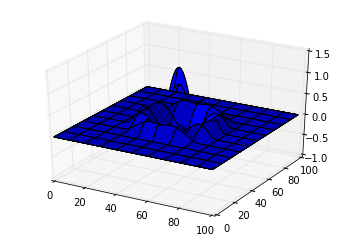

In [8]:
#Create test input data
nx = 100;
ny = nx;
initialCond = 0.5;
u0 = np.zeros((nx,ny),dtype=np.float32);
xo_val = np.arange(-pi/2.0,pi/2.0,pi/20.0, dtype=np.float32);
yo_val = np.arange(-pi/2.0,pi/2.0,pi/20.0, dtype=np.float32);
xo_val,yo_val = np.meshgrid(xo_val,yo_val);
u0[nx/2-10:nx/2+10,ny/2-10:ny/2+10] = 1.5*np.cos(xo_val)*np.cos(yo_val);

#u0[0,:] = initialCond;
#u0[nx-1,:] = initialCond;
#u0[:,0] = initialCond;
#u0[:,ny-1] = initialCond;

cl_data = HeatDataCL_2D(u0)
kappa = 1.0
dx = 1.0
dy = 1.0
Xaxis = numpy.arange(0,nx,dx);
Yaxis = numpy.arange(0,ny,dy);
Xaxis, Yaxis = numpy.meshgrid(Xaxis,Yaxis);

#Plot initial conditions
fig = figure()
ax = fig.gca(projection='3d')
#ax.plot_surface(Xaxis, Yaxis, u0);

for i in range(1, 10):
    timesteps_per_plot=10
    #Simulate 10 timesteps
    opencl_wave_eq_2D(cl_data, kappa, dx, dy, timesteps_per_plot)

    #Download data
    u2 = cl_data.download()
    
    #Plot
    ax.plot_surface(Xaxis, Yaxis, u2);

In [9]:
cl.platform_info()

RuntimeError: This class cannot be instantiated from Python

In [12]:
cl.get_platform()

AttributeError: 'module' object has no attribute 'get_platform'

In [21]:
availPlatforms = cl.get_platforms()[0]

In [19]:
availPlatforms.get_devices()

[<pyopencl.Device 'Intel(R) Core(TM) i7-4712MQ CPU @ 2.30GHz' on 'Intel(R) OpenCL' at 0x3704068>]